# S&DE Atelier - Visual Analytics

# Assignment 3

**Due** June 2, 2023 @23:55

**Contacts**: [marco.dambros@usi.ch](mailto:marco.dambros@usi.ch) - [carmen.armenti@usi.ch](mailto:carmen.armenti@usi.ch)

---

The goal of this assignment is to use Spark in Jupyter notebooks (PySpark). The files `trip_data.csv`, `trip_fare.csv` and `nyc_boroughs.geojson` can be found in the following folder: [Assignment3-data](https://usi365-my.sharepoint.com/:f:/g/personal/armenc_usi_ch/Ejp7sb8QAMROoWe0XUDcAkMBoqUFk-w2Vgroup025NhAww?e=TFG5CD). You should clean the data if needed. 

Note that you can use Spark [window functions](https://spark.apache.org/docs/latest/sql-ref-syntax-qry-select-window.html) whenever applicable.  

Please name your file as `SurnameName_Assignment3.ipynb`.

In [1]:
# Import the basic spark library
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from math import pi
from bokeh.models import BasicTicker, PrintfTickFormatter
from bokeh.plotting import figure, show
from bokeh.transform import linear_cmap
from pyspark.sql import types as T
from pyspark.sql import functions as F
from pyspark.sql import Window
from shapely.geometry import Polygon, Point
from typing import Tuple, List
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
# Create an entry point to the PySpark Application
spark = SparkSession.builder \
      .config("spark.driver.bindAddress", "127.0.0.1") \
      .config("spark.driver.memory", "16g") \
      .config("spark.executor.memory", "16g") \
      .config("spark.executor.cores", "4") \
      .config("spark.executor.memory", "16g") \
      .master("local") \
      .appName("MaggioniClaudio_Assignment3") \
      .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/31 16:53:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Exercise 1
Join the `trip_data` and `trip_fare` dataframes into one and consider only data on 2013-01-01.

In [3]:
def sanitize_column_names(df):
    for original, renamed in [(x, x.strip().replace(" ", "_"),) for x in df.columns]:
        df = df.withColumnRenamed(original, renamed)
    return df

In [4]:
df_trip_data = spark.read \
    .option("header", True) \
    .csv("data/trip_data.csv", inferSchema=True)

df_trip_data = sanitize_column_names(df_trip_data)

In [5]:
df_trip_fare = spark.read \
    .option("header", True) \
    .csv("data/trip_fare.csv", inferSchema=True)

df_trip_fare = sanitize_column_names(df_trip_fare)

In [6]:
df_trip_data.show()

+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|           medallion|        hack_license|vendor_id|rate_code|store_and_fwd_flag|    pickup_datetime|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|
+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|89D227B655E5C82AE...|BA96DE419E711691B...|      CMT|        1|                 N|2013-01-01 15:11:48|2013-01-01 15:18:10|              4|              382|          1.0|      -73.978165|      40.757977|       -73.989838|       40.751171|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...| 

In [7]:
df_trip_fare.show()

+--------------------+--------------------+---------+-------------------+------------+-----------+---------+-------+----------+------------+------------+
|           medallion|        hack_license|vendor_id|    pickup_datetime|payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|
+--------------------+--------------------+---------+-------------------+------------+-----------+---------+-------+----------+------------+------------+
|89D227B655E5C82AE...|BA96DE419E711691B...|      CMT|2013-01-01 15:11:48|         CSH|        6.5|      0.0|    0.5|       0.0|         0.0|         7.0|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...|      CMT|2013-01-06 00:18:35|         CSH|        6.0|      0.5|    0.5|       0.0|         0.0|         7.0|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...|      CMT|2013-01-05 18:49:41|         CSH|        5.5|      1.0|    0.5|       0.0|         0.0|         7.0|
|DFD2202EE08F7A8DC...|51EE87E3205C985EF...|      CMT|2013-01-07 23:54:15|   

In [8]:
df_left = df_trip_data.filter(col('pickup_datetime').startswith("2013-01-01 "))
df_right = df_trip_fare.filter(col('pickup_datetime').startswith("2013-01-01 "))

df_joined = df_left.join(df_right, ['medallion', 'pickup_datetime']).cache()

In [9]:
df_joined.show(3)

+--------------------+-------------------+--------------------+---------+---------+------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+--------------------+---------+------------+-----------+---------+-------+----------+------------+------------+
|           medallion|    pickup_datetime|        hack_license|vendor_id|rate_code|store_and_fwd_flag|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|        hack_license|vendor_id|payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|
+--------------------+-------------------+--------------------+---------+---------+------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+--------------------+---------+------------+-----------+------

### Exercise 2
Consider only Manhattan, Bronx and Brooklyn districts. Then create a dataframe that shows the total number of trips *within* the same district and *across* all the other districts mentioned before.

For example, for Manhattan borough you should consider the total number of the following trips:
- Manhattan → Manhattan
- Manhattan → Brooklyn
- Manhattan → Bronx

You should then do the same for Bronx and Brooklyn boroughs.

In [10]:
df_boroughs = spark.read \
    .option("multiline", "true") \
    .json(r'data/nyc-boroughs.geojson')

df_boroughs = df_boroughs.select(F.explode(df_boroughs.features).alias("feature"))

boroughs_list = df_boroughs.select( \
    df_boroughs.feature.properties.borough.alias("borough"), \
    df_boroughs.feature.geometry.coordinates.alias("coordinates")).collect()

boroughs_list: list[tuple[str, list[Polygon]]] = \
    [(r.borough, [Polygon(shell=p) for p in r.coordinates]) for r in boroughs_list]

@F.udf(returnType=T.StringType())
def get_borough(lon: float, lat: float) -> bool:
    global boroughs_list

    if lon is None or lat is None:
        return None

    point = Point(lon, lat)
    
    for b in boroughs_list:
        for p in b[1]:
            if p.contains(point):
                return b[0]
    return None

In [11]:
# use UDF as join condition
df_with_bor = df_joined \
    .withColumn("pickup_borough", get_borough("pickup_longitude", "pickup_latitude")) \
    .withColumn("dropoff_borough", get_borough("dropoff_longitude", "dropoff_latitude")) \
    .cache()

In [12]:
def isin(var, values):
    cond = (var == values[0])
    for i in range(0, len(values)):
        cond = cond | (var == values[i])
    return cond

boroughs = ["Manhattan", "Bronx", "Brooklyn"]
df_ex2 = df_with_bor \
    .where((isin(df_with_bor.pickup_borough, boroughs)) & (isin(df_with_bor.dropoff_borough, boroughs))) \
    .groupBy("pickup_borough", "dropoff_borough") \
    .count() \
    .orderBy("pickup_borough", "dropoff_borough")
df_ex2.show(truncate=False)

+--------------+---------------+------+
|pickup_borough|dropoff_borough|count |
+--------------+---------------+------+
|Bronx         |Bronx          |487   |
|Bronx         |Brooklyn       |6     |
|Bronx         |Manhattan      |284   |
|Brooklyn      |Bronx          |57    |
|Brooklyn      |Brooklyn       |10454 |
|Brooklyn      |Manhattan      |6408  |
|Manhattan     |Bronx          |2779  |
|Manhattan     |Brooklyn       |14396 |
|Manhattan     |Manhattan      |319706|
+--------------+---------------+------+



### Exercise 3
Imagine you are a taxi driver and one day you can work only two hours. Assume the data is representative of a typical working day. Which hours of the day - retrieved from `pickup_datetime` - would you choose to work based on the fare and tip amount?

In [13]:
df_ex3 = df_joined.select( \
    F.hour(F.from_utc_timestamp(df_joined.pickup_datetime, 'UTC')).alias('pickup_hour'), \
    F.col("fare_amount"), \
    F.col("tip_amount")) \
    .groupby("pickup_hour") \
    .agg(F.round(F.sum(F.col("fare_amount") + F.col("tip_amount")), 2).alias('fare_and_tip_total')) \
    .select("pickup_hour", "fare_and_tip_total") \
    .sort(F.desc("fare_and_tip_total"))

df_ex3.show(24)

+-----------+------------------+
|pickup_hour|fare_and_tip_total|
+-----------+------------------+
|          1|         453700.23|
|          2|         418415.82|
|          0|         390741.27|
|          3|         367018.78|
|         14|         286852.68|
|         15|         278953.43|
|          4|         272856.05|
|         18|         269648.14|
|         13|         263915.72|
|         17|         258134.56|
|         16|         246552.73|
|         12|         238716.32|
|         19|         234377.86|
|         20|         211402.98|
|         21|         208110.83|
|         22|         204481.56|
|         11|         194952.87|
|          5|          180075.5|
|         23|         158957.41|
|         10|         146400.51|
|          6|         135810.97|
|          7|         118466.26|
|          9|         111925.58|
|          8|          99021.68|
+-----------+------------------+



Given the table above I would choose to work at **1 AM** and **2 AM** as they are the most profitable hours based on total fare and tip amount. This may be the case for the chosen date `2013-01-01` because of the new year celebrations.

### Exercise 4
Provide a graphical representation to compare the average fare amount for trips _within_ and _across_ all the districts. You may want to have a look at: https://docs.bokeh.org/en/latest/docs/user_guide/topics/categorical.html#heatmaps.

In [14]:
ex4_data = df_with_bor \
    .withColumn("pickup_borough", F.coalesce(F.col("pickup_borough"), F.lit("Unknown"))) \
    .withColumn("dropoff_borough", F.coalesce(F.col("dropoff_borough"), F.lit("Unknown"))) \
    .groupBy("pickup_borough", "dropoff_borough") \
    .agg(F.mean(F.col('fare_amount')).alias('mean_fare_amount')) \
    .collect()

df_ex4 = pd.DataFrame()
for i, row in enumerate(ex4_data):
    df_ex4.loc[i, 'pickup_borough'] = row.pickup_borough
    df_ex4.loc[i, 'dropoff_borough'] = row.dropoff_borough
    df_ex4.loc[i, 'mean_fare'] = row.mean_fare_amount

In [15]:
pickup = list(sorted(df_ex4['pickup_borough'].unique()))
dropoff = list(reversed(sorted(df_ex4['dropoff_borough'].unique())))

colors = ["#75968f", "#a5bab7", "#c9d9d3", "#e2e2e2", "#dfccce", "#ddb7b1", "#cc7878", "#933b41", "#550b1d"]

p = figure(title=f"Mean NYC Taxi fares on 2013-01-01",
           x_range=pickup, y_range=dropoff,
           x_axis_location="above", width=900, height=900,
           tools="hover,save,pan,box_zoom,reset,wheel_zoom", toolbar_location='below',
           tooltips=[ \
               ('Pickup Borough', '@pickup_borough'), \
               ('Dropoff Borough', '@dropoff_borough'), \
               ('Average Fare Amount', '$@mean_fare')])

p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "14px"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = pi / 3

r = p.rect(x="pickup_borough", y="dropoff_borough", width=1, height=1, source=df_ex4,
           fill_color=linear_cmap("mean_fare", colors, low=df_ex4.mean_fare.min(), high=df_ex4.mean_fare.max()),
           line_color=None)

p.add_layout(r.construct_color_bar(
    major_label_text_font_size="14px",
    ticker=BasicTicker(desired_num_ticks=len(colors)),
    formatter=PrintfTickFormatter(format="$%d"),
    label_standoff=6,
    border_line_color=None,
    padding=5
), 'right')

show(p)

### Exercise 5
Find the average amount of tolls per hour for trips within the following districts: Manhattan, Bronx, Brooklyn, Queens. Show a graphical representation of the data and report if there is any trend or peak during the day. Overall which district has the largest amount of tolls?

<Axes: xlabel='Hour of day of 2013-01-01', ylabel='Mean toll amount'>

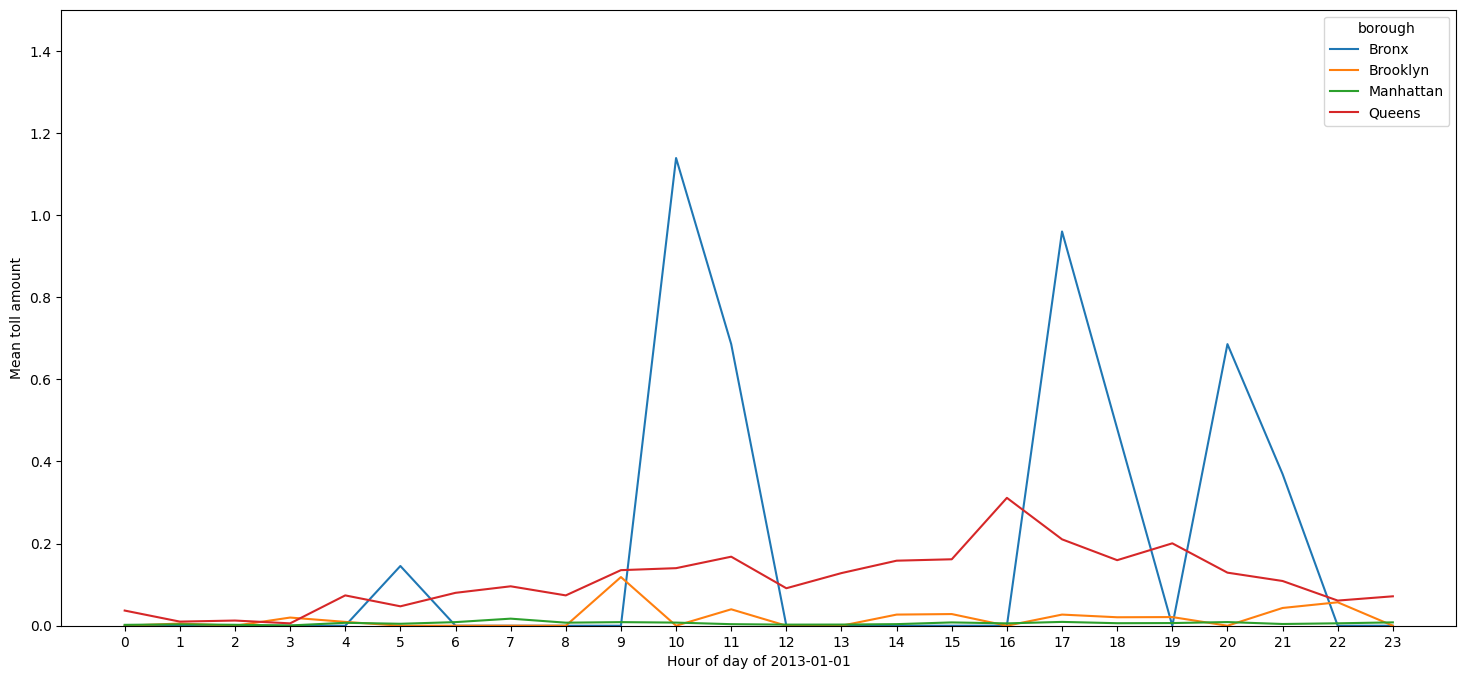

In [16]:
boroughs_ex5 = ["Manhattan", "Bronx", "Brooklyn", "Queens"]

ex5_data = df_with_bor \
    .where((isin(df_with_bor.pickup_borough, boroughs_ex5)) & (df_with_bor.pickup_borough == df_with_bor.dropoff_borough)) \
    .withColumn("hour", F.hour(F.from_utc_timestamp(F.col("pickup_datetime"), 'UTC'))) \
    .groupBy("pickup_borough", "dropoff_borough", "hour") \
    .agg(F.mean(F.col('tolls_amount')).alias('mean_tolls_amount')) \
    .select(F.col('pickup_borough').alias('borough'), F.col('hour'), F.col('mean_tolls_amount')) \
    .orderBy("borough", "hour") \
    .collect()

df_ex5 = pd.DataFrame()
for i, row in enumerate(ex5_data):
    df_ex5.loc[i, 'borough'] = row.borough
    df_ex5.loc[i, 'hour'] = row.hour
    df_ex5.loc[i, 'mean_tolls_amount'] = row.mean_tolls_amount

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(18, 8))
ax.set(ylabel="Mean toll amount", ylim=[0, 1.5], xticks=range(24), 
       xlabel="Hour of day of 2013-01-01")
sns.lineplot(data=df_ex5, x="hour", y="mean_tolls_amount", hue="borough")

For trips within _Bronx_, there are several toll amount peaks, namely in decreasing order of magnitude between 10 AM and 11 AM, at 5 PM, at 8 PM and at 5 AM. Trips within _Queens_ show a steady toll amount increase peaking at 4 PM and then decreasing again. 

In [17]:
df_ex5.groupby("borough").sum().loc[:, ["mean_tolls_amount"]].sort_values("mean_tolls_amount", ascending=False)

mean_tolls_amount
borough                     
Bronx               4.465003
Queens              2.672513
Brooklyn            0.417684
Manhattan           0.145958

As shown by the table above, _Bronx_ is the borough with the overall highest toll amounts for within-borough trips on 2013-01-01.

### Exercise 6
Create a dataframe that for each district shows the shortest and longest `trip_distance` starting and ending in the same district. What is the length of the longest and shortest trips in Manhattan?

In [18]:
df_ex6 = df_with_bor \
    .where((df_with_bor.pickup_borough == df_with_bor.dropoff_borough) & (df_with_bor.pickup_borough.isNotNull())) \
    .groupBy("pickup_borough") \
    .agg(F.min('trip_distance').alias('min_trip_distance'), F.max('trip_distance').alias('max_trip_distance')) \
    .withColumnRenamed("pickup_borough", "borough") \
    .orderBy("borough")

df_ex6.show(truncate=False)

+-------------+-----------------+-----------------+
|borough      |min_trip_distance|max_trip_distance|
+-------------+-----------------+-----------------+
|Bronx        |0.0              |20.0             |
|Brooklyn     |0.0              |80.5             |
|Manhattan    |0.0              |100.0            |
|Queens       |0.0              |98.7             |
|Staten Island|0.0              |5.7              |
+-------------+-----------------+-----------------+



The shortest trip within _Manhattan_ has distance $= 0$ while the longest one has distance $= 100$.

### Exercise 7
Consider only the trips _within_ districts. What are the first and second-most expensive
trips - based on `total_amount` - in every district?

In [26]:
w = Window.partitionBy("borough").orderBy(F.col("total_amount").desc())

df_ex7 = df_with_bor \
    .where((df_with_bor.pickup_borough == df_with_bor.dropoff_borough) & (df_with_bor.pickup_borough.isNotNull())) \
    .withColumnRenamed("pickup_borough", "borough") \
    .withColumn("rank", F.rank().over(w)) \
    .where(F.col("rank") <= 2) \

df_ex7.show()

+--------------------+-------------------+--------------------+---------+---------+------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+--------------------+---------+------------+-----------+---------+-------+----------+------------+------------+-------------+---------------+----+
|           medallion|    pickup_datetime|        hack_license|vendor_id|rate_code|store_and_fwd_flag|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|        hack_license|vendor_id|payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|      borough|dropoff_borough|rank|
+--------------------+-------------------+--------------------+---------+---------+------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+---------

The dataframe above shows the most expensive (with `rank` $=1$) and second most expensive (with `rank` $=2$) within-district trip data for each district.

### Exercise 8
Create a dataframe where each row represents a driver, and there is one column per district.
For each driver-district, the dataframe provides the maximum number of consecutive trips
for the given driver, within the given district. 

For example, if for driver A we have (sorted by time):
- Trip 1: Bronx → Bronx
- Trip 2: Bronx → Bronx
- Trip 3: Bronx → Manhattan
- Trip 4: Manhattan → Bronx.
    
The maximum number of consecutive trips for Bronx is 2.

In [50]:
w_ex8 = Window.partitionBy("medallion").orderBy(F.col("pickup_datetime"))

@F.udf(returnType=T.IntegerType())
def max_consecutive_rank_seq_len(ranks: list[int]) -> int:
    if len(ranks) <= 1:
        return len(ranks)

    longest_len = 0
    start = 0
    
    for i, rank in enumerate(ranks):
        if i == 0:
            continue
        if rank - 1 != ranks[i - 1]:
            longest_len = max(i - start, longest_len)
            start = i
            
    longest_len = max(len(ranks) - start, longest_len) 
    return longest_len

df_ex8 = df_with_bor \
    .select("medallion", "pickup_borough", "dropoff_borough", "pickup_datetime") \
    .withColumn("tripNo", F.rank().over(w_ex8)) \
    .where((F.col("pickup_borough") == F.col("dropoff_borough")) & (F.col("pickup_borough").isNotNull())) \
    .select(F.col("medallion"), F.col("pickup_borough").alias("borough"), F.col("tripNo")) \
    .groupBy("medallion", "borough").agg(max_consecutive_rank_seq_len(F.collect_list("tripNo")).alias('maxTrips')) \
    .groupBy("medallion").pivot("borough").sum("maxTrips") \
    .fillna(value=0)

df_ex8.show(100)

+--------------------+-----+--------+---------+------+-------------+
|           medallion|Bronx|Brooklyn|Manhattan|Queens|Staten Island|
+--------------------+-----+--------+---------+------+-------------+
|35E11D9D2AE5C8A80...|    0|       1|       15|     5|            0|
|DA350783B6954CC67...|    0|       0|       27|     0|            0|
|35B2F21FAF5E53F1E...|    0|       3|        8|     3|            0|
|6695FB6E06F7D99F5...|    0|       1|       21|     0|            0|
|36372627462019376...|    0|       0|        5|     2|            0|
|EF882BDAF03D41517...|    0|       0|       17|     1|            0|
|846DFE2D59F6E76EC...|    0|       1|       25|     0|            0|
|9B69C5971F62F151B...|    0|       0|       13|     1|            0|
|0F621E366CFE63044...|    0|       1|       11|     1|            0|
|87EB479F55B88D47C...|    0|       1|       19|     0|            0|
|4EE5F2532F57F2124...|    0|       0|       14|     1|            0|
|4F4CA97166A04A455...|    0|      